In [1]:
import sqlite3 as sql
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns

In [2]:
conn = sql.connect('Northwind_small.sqlite')
cur = conn.cursor()

In [3]:
table_names = list(cur.execute('''SELECT name FROM sqlite_master WHERE TYPE = 'table'
                               ''').fetchall())
table_names

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

In [4]:
sql_comm = []
for i in range(0,len(table_names)):
    s = "SELECT * FROM " + table_names[i][0]
    sql_comm.append(s)

employees = pd.read_sql_query(sql_comm[0], conn)
categories = pd.read_sql_query(sql_comm[1], conn)
customers = pd.read_sql_query(sql_comm[2], conn)
shippers = pd.read_sql_query(sql_comm[3], conn)

suppliers = pd.read_sql_query(sql_comm[4], conn)
products = pd.read_sql_query(sql_comm[6], conn)
order_details = pd.read_sql_query(sql_comm[7], conn)
orders = pd.read_csv('Order.csv')

cust_cust_demos = pd.read_sql_query(sql_comm[8], conn)
cust_demos = pd.read_sql_query(sql_comm[9], conn)
regions = pd.read_sql_query(sql_comm[10], conn)
territories = pd.read_sql_query(sql_comm[11], conn)
emp_territories = pd.read_sql_query(sql_comm[12], conn)

In [5]:
order_details.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [6]:
order_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [19]:
order_details.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


In [7]:
round(ols(formula='Quantity ~ Discount', data=order_details).fit().pvalues,5)

Intercept    0.0
Discount     0.0
dtype: float64

In [8]:
round(ols(formula='Quantity ~ Discount*UnitPrice', data=order_details).fit().pvalues,5)

Intercept             0.00000
Discount              0.00062
UnitPrice             0.72206
Discount:UnitPrice    0.18165
dtype: float64

In [9]:
orders.ShipCountry.value_counts()

USA            122
Germany        122
Brazil          83
France          77
UK              56
Venezuela       46
Austria         40
Sweden          37
Canada          30
Italy           28
Mexico          28
Spain           23
Finland         22
Belgium         19
Ireland         19
Denmark         18
Switzerland     18
Argentina       16
Portugal        13
Poland           7
Norway           6
Name: ShipCountry, dtype: int64

In [10]:
orders.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [11]:
order_countries = orders[['Id','ShipCountry']]

In [12]:
order_disc_quan = order_details[['OrderId','Discount','Quantity']]

In [13]:
df = pd.merge(order_countries, 
                  order_disc_quan,
                  left_on='Id',
                  right_on='OrderId',
                  how='left')

In [14]:
df.head()

,Id,ShipCountry,OrderId,Discount,Quantity
0,10248,France,10248,0.0,12
1,10248,France,10248,0.0,10
2,10248,France,10248,0.0,5
3,10249,Germany,10249,0.0,9
4,10249,Germany,10249,0.0,40


In [15]:
df = df.join(pd.get_dummies(df.ShipCountry))
df.drop('ShipCountry', axis=1,inplace=True)

In [16]:
df.head()

,Id,OrderId,Discount,Quantity,Argentina,Austria,Belgium,Brazil,Canada,Denmark,...,Mexico,Norway,Poland,Portugal,Spain,Sweden,Switzerland,UK,USA,Venezuela
0,10248,10248,0.0,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10248,10248,0.0,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10248,10248,0.0,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10249,10249,0.0,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10249,10249,0.0,40,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
columns = "+Discount*".join(df.drop(['Quantity', 'OrderId', 'Id', 'Discount'], axis=1).columns)
f = 'Quantity~' + columns
round(ols(formula=f, data=df).fit().pvalues,5)

Intercept               0.00000
Argentina               0.00148
Discount                0.00793
Austria                 0.00000
Discount:Austria        0.80675
Belgium                 0.06913
Discount:Belgium        0.95399
Brazil                  0.28254
Discount:Brazil         0.15655
Canada                  0.08433
Discount:Canada         0.24064
Denmark                 0.05474
Discount:Denmark        0.50017
Finland                 0.17757
Discount:Finland        0.99639
France                  0.22033
Discount:France         0.42195
Germany                 0.00000
Discount:Germany        0.54808
Ireland                 0.02883
Discount:Ireland        0.59266
Italy                   0.19352
Discount:Italy          0.65784
Mexico                  0.00988
Discount:Mexico         0.73811
Norway                  0.02897
Discount:Norway         0.49321
Poland                  0.12220
Discount:Poland         0.78604
Portugal                0.74382
Discount:Portugal       0.61090
Spain   

In [18]:
order_details.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

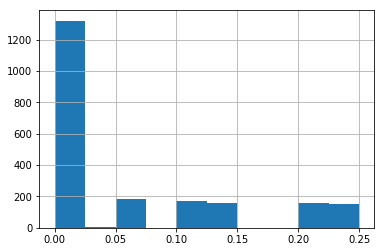

In [45]:
order_details.Discount.hist()

In [57]:
disc_05 = order_details[['Quantity','Discount']][(order_details.Discount<0.05) & (order_details.Discount>0)]
disc_15 = order_details[['Quantity','Discount']][(order_details.Discount<0.15) & (order_details.Discount > 0.05)]
disc_25 = order_details[['Quantity','Discount']][order_details.Discount>0.15]
print("Less than 5% : " + str(round(ols(formula='Quantity ~ Discount', data=disc_05).fit().pvalues[1],5)))
print("Between 5% and 15% : " + str(round(ols(formula='Quantity ~ Discount', data=disc_15).fit().pvalues[1],5)))
print("Between 15% and 25% : " + str(round(ols(formula='Quantity ~ Discount', data=disc_25).fit().pvalues[1],5)))

Less than 5% : 0.34871
Between 5% and 15% : 0.27565
Between 15% and 25% : 0.58015


In [135]:
d = 0
for i in sorted(order_details.Discount.unique()):
    d = order_details[['Quantity', 'Discount']][order_details.Discount==i].copy()
    print(str(i)+ " : " + str(ols(formula='Quantity ~ Discount', data=d).fit().pvalues[1]))

C:\Users\sparr\Anaconda3\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\sparr\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\sparr\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\sparr\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\sparr\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1510: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
C:\Users\sparr\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1510: RuntimeWarning: invalid value 

0.0 : nan
0.01 : nan
0.02 : 0.2951672353008664
0.03 : 0.037749551350623724
0.04 : nan
0.05 : 4.5477484785587396e-40
0.06 : nan
0.1 : 6.00589433967154e-35
0.15 : 2.4926940742089617e-37
0.2 : 7.745444908882207e-41
0.25 : 3.864037164219324e-38


In [35]:
no_disc = order_details[order_details['Discount'] == 0].copy()
disc = order_details[order_details['Discount'] > 0].copy()
print(no_disc.Quantity.mean())
print(disc.Quantity.mean())

21.715261958997722
27.10978520286396


In [36]:
from scipy import stats
print(stats.ttest_ind(no_disc.Quantity, disc.Quantity))

Ttest_indResult(statistic=-6.4785631962949015, pvalue=1.1440924523215966e-10)


In [37]:
disc_5 = order_details['Quantity'][order_details['Discount'] <= 0.05]
disc_10 = order_details['Quantity'][(order_details['Discount'] > 0.05) & (order_details['Discount'] <= 0.1)]
disc_15 = order_details['Quantity'][(order_details['Discount'] > 0.1) & (order_details['Discount'] <= 0.15)]
disc_20 = order_details['Quantity'][(order_details['Discount'] > 0.15) & (order_details['Discount'] <= 0.2)]
disc_25 = order_details['Quantity'][order_details['Discount'] > 0.2]
buckets = [(0.05, disc_5), (0.1, disc_10), (0.15, disc_15), (0.2, disc_20), (0.25,disc_25)]
c = 0 
while c < len(buckets) - 1:
    x = buckets[c][1]
    y = buckets[c+1][1]
    p = stats.ttest_ind(x,y)[1]
    print(str(buckets[c][0]) + " v.s. " + str(buckets[c+1][0]) + " : " + str(p)) 
    c += 1

0.05 v.s. 0.1 : 0.06894702109397166
0.1 v.s. 0.15 : 0.15837034442401487
0.15 v.s. 0.2 : 0.5433964640207652
0.2 v.s. 0.25 : 0.5801473824667989


In [42]:
for i in sorted(disc.Discount.unique(), reverse=True):
    x = order_details['Quantity'][order_details['Discount'] <= i]
    y = no_disc.Quantity
    p = stats.ttest_ind(x,y)[1]
    print(str(i) + " or less : " + str(p))

0.25 or less : 0.0011709565654773784
0.2 or less : 0.007027185205959757
0.15 or less : 0.028794089136635528
0.1 or less : 0.1505882586541458
0.06 or less : 0.3246922039243668
0.05 or less : 0.315021315805612
0.04 or less : 0.8767246322932662
0.03 or less : 0.8947821335281937
0.02 or less : 0.9476193414318629
0.01 or less : 0.9825069543456303


In [43]:
for i in sorted(disc.Discount.unique()):
    x = order_details['Quantity'][order_details['Discount'] >= i]
    y = no_disc.Quantity
    p = stats.ttest_ind(x,y)[1]
    print(str(i) + " or higher : " + str(p))

0.01 or higher : 1.1440924523215966e-10
0.02 or higher : 9.119093884418095e-11
0.03 or higher : 5.76492092672185e-11
0.04 or higher : 2.830700618487935e-11
0.05 or higher : 2.208943233062508e-11
0.06 or higher : 1.2858627864913951e-09
0.1 or higher : 9.92659359846411e-10
0.15 or higher : 3.4195826530973737e-10
0.2 or higher : 1.639960845913213e-07
0.25 or higher : 1.780928988051903e-05


In [46]:
prod_ord_details = pd.merge(products, 
                  order_details,
                  left_on='Id',
                  right_on='ProductId',
                  how='left')
prod_ord_details.head()

,Id_x,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice_x,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id_y,OrderId,ProductId,UnitPrice_y,Quantity,Discount
0,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10285/1,10285,1,14.4,45,0.20
1,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10294/1,10294,1,14.4,18,0.00
2,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10317/1,10317,1,14.4,20,0.00
3,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10348/1,10348,1,14.4,15,0.15
4,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10354/1,10354,1,14.4,12,0.00


In [47]:
prod_ord_details_cat = pd.merge(prod_ord_details, 
                  categories,
                  left_on='CategoryId',
                  right_on='Id',
                  how='left')
prod_ord_details_cat.head()

,Id_x,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice_x,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id_y,OrderId,ProductId,UnitPrice_y,Quantity,Discount,Id,CategoryName,Description
0,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10285/1,10285,1,14.4,45,0.20,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10294/1,10294,1,14.4,18,0.00,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
2,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10317/1,10317,1,14.4,20,0.00,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
3,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10348/1,10348,1,14.4,15,0.15,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
4,1,Chai,1,1,10 boxes x 20 bags,18.0,39,0,10,0,10354/1,10354,1,14.4,12,0.00,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"


In [48]:
df_cat_disc = prod_ord_details_cat.filter(['Quantity', 'Discount','CategoryName'], axis=1)
df_cat_disc = prod_ord_details_cat.join(pd.get_dummies(df_cat_disc.CategoryName))
df_cat_disc.CategoryName.unique()

array(['Beverages', 'Condiments', 'Produce', 'Meat/Poultry', 'Seafood',
       'Dairy Products', 'Confections', 'Grains/Cereals'], dtype=object)

In [49]:
a = prod_ord_details_cat[['Quantity', 'Discount', 'CategoryName']].copy()
a = a.join(pd.get_dummies(a.CategoryName))
a.drop('CategoryName', axis=1, inplace=True)
a.columns = [c.replace(' ', '_') for c in a.columns]
a.columns = [c.replace('/', '_') for c in a.columns]

In [50]:
a.head()

,Quantity,Discount,Beverages,Condiments,Confections,Dairy_Products,Grains_Cereals,Meat_Poultry,Produce,Seafood
0,45,0.20,1,0,0,0,0,0,0,0
1,18,0.00,1,0,0,0,0,0,0,0
2,20,0.00,1,0,0,0,0,0,0,0
3,15,0.15,1,0,0,0,0,0,0,0
4,12,0.00,1,0,0,0,0,0,0,0


In [62]:
cats = a.iloc[:,3:].columns
for i in cats:
    x = a['Quantity'][(a[i]== 1) & (a['Discount'] > 0)]
    y = a['Quantity'][(a[i]== 1) & (a['Discount'] == 0)]
    p = stats.ttest_ind(x,y)[1]
    print(i + " : " + str(p))

Condiments : 0.0028684089653436572
Confections : 0.45352129409883224
Dairy_Products : 0.0002666228960405692
Grains_Cereals : 0.5552715810956148
Meat_Poultry : 0.017249856422011725
Produce : 0.3578580884965371
Seafood : 0.028748172062955896


In [110]:
ord_det = pd.merge(order_details, 
                  orders,
                  left_on='OrderId',
                  right_on='Id',
                  how='left')
ord_det_emp = pd.merge(ord_det,
                      employees,
                      left_on='EmployeeId',
                      right_on='Id',
                      how='left')
ord_det_emp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2155 entries, 0 to 2154
Data columns (total 38 columns):
Id_x               2155 non-null object
OrderId            2155 non-null int64
ProductId          2155 non-null int64
UnitPrice          2155 non-null float64
Quantity           2155 non-null int64
Discount           2155 non-null float64
Id_y               2155 non-null int64
CustomerId         2155 non-null object
EmployeeId         2155 non-null int64
OrderDate          2155 non-null object
RequiredDate       2155 non-null object
ShippedDate        2082 non-null object
ShipVia            2155 non-null int64
Freight            2155 non-null float64
ShipName           2155 non-null object
ShipAddress        2155 non-null object
ShipCity           2155 non-null object
ShipRegion         2155 non-null object
ShipPostalCode     2100 non-null object
ShipCountry        2155 non-null object
Id                 2155 non-null int64
LastName           2155 non-null object
FirstName        

In [143]:
for i in ord_det_emp.Id.unique():
    sales = (ord_det_emp['Quantity'][ord_det_emp['Id'] == i]) * (ord_det_emp['UnitPrice'][ord_det_emp['Id'] == i])
    print (str(i) + " " + ord_det_emp['Title'][ord_det_emp['Id'] == i].unique() + " : " + str(round(sales.sum(),1)))
    #print(ord_det_emp[i])

['5 Sales Manager : 75567.8']
['6 Sales Representative : 78198.1']
['4 Sales Representative : 250187.4']
['3 Sales Representative : 213051.3']
['9 Sales Representative : 82964.0']
['1 Sales Representative : 202143.7']
['8 Inside Sales Coordinator : 133301.0']
['2 Vice President, Sales : 177749.3']
['7 Sales Representative : 141296.0']


In [160]:
def get_sales(ID):
    sales = (ord_det_emp['Quantity'][ord_det_emp['Id'] == ID]) * (ord_det_emp['UnitPrice'][ord_det_emp['Id'] == ID])
    return sales

In [146]:
def get_total_sales(ID):
    sales = (ord_det_emp['Quantity'][ord_det_emp['Id'] == ID]) * (ord_det_emp['UnitPrice'][ord_det_emp['Id'] == ID])
    return sales.sum()

In [153]:
x = []
for i in [6,4,3,9,1,7]:
    x.append(get_total_sales(i))
y = []
for i in [5,8,2]:
    y.append(get_total_sales(i))
stats.ttest_ind(x,y)

Ttest_indResult(statistic=0.6899312380819096, pvalue=0.5124543318082981)

In [166]:
for i in sorted(ord_det_emp.Id.unique()):
    for j in sorted(ord_det_emp.Id.unique()):
        if j <= i:
            pass
        else:
            x = get_sales(i)
            y = get_sales(j)
            p = stats.ttest_ind(x,y)[1]
            if p <= 0.05:
                print(str(i) + " v.s. " + str(j) + " : " + str(round(p,3)))
            

2 v.s. 6 : 0.015
2 v.s. 8 : 0.013
3 v.s. 6 : 0.021
3 v.s. 8 : 0.03
4 v.s. 7 : 0.033
6 v.s. 7 : 0.005
6 v.s. 9 : 0.009
7 v.s. 8 : 0.003
8 v.s. 9 : 0.007


In [151]:
ord_det_emp.BirthDate.unique()

array(['1987-03-04', '1995-07-02', '1969-09-19', '1995-08-30',
       '1998-01-27', '1980-12-08', '1990-01-09', '1984-02-19',
       '1992-05-29'], dtype=object)

In [127]:
ord_det_emp.Id.unique()

array([5, 6, 4, 3, 9, 1, 8, 2, 7], dtype=int64)

In [103]:
reps_data = []
for i in sales_reps_IDs:
    ord = orders['Id'][orders['EmployeeId'] == i]
    details = []
    for j in ord:
        details.append(order_details[order_details['OrderId'] == j])
    reps_data.append([i, details])


In [107]:
for i in range (0, len(reps_data)):
    print(pd.DataFrame(reps_data[i][1][1].info()))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 59 to 60
Data columns (total 6 columns):
Id           2 non-null object
OrderId      2 non-null int64
ProductId    2 non-null int64
UnitPrice    2 non-null float64
Quantity     2 non-null int64
Discount     2 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 112.0+ bytes
Empty DataFrame
Columns: []
Index: []
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 76 to 77
Data columns (total 6 columns):
Id           2 non-null object
OrderId      2 non-null int64
ProductId    2 non-null int64
UnitPrice    2 non-null float64
Quantity     2 non-null int64
Discount     2 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 112.0+ bytes
Empty DataFrame
Columns: []
Index: []
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 14 to 16
Data columns (total 6 columns):
Id           3 non-null object
OrderId      3 non-null int64
ProductId    3 non-null int64
UnitPrice    3 non-null

In [106]:
orders.EmployeeId.value_counts()

4    156
3    127
1    123
8    104
2     96
7     72
6     67
9     43
5     42
Name: EmployeeId, dtype: int64